In [1]:
!pip install xgboost


Train shape: (444, 2)
Test shape: (195, 1)

Grade distribution:
grade
A    168
C    127
B     75
D     74
Name: count, dtype: int64

✅ Validation Accuracy: 53.93%

Classification Report:
              precision    recall  f1-score   support

           A       0.68      0.79      0.73        34
           B       0.33      0.07      0.11        15
           C       0.39      0.52      0.45        25
           D       0.54      0.47      0.50        15

    accuracy                           0.54        89
   macro avg       0.49      0.46      0.45        89
weighted avg       0.52      0.54      0.51        89



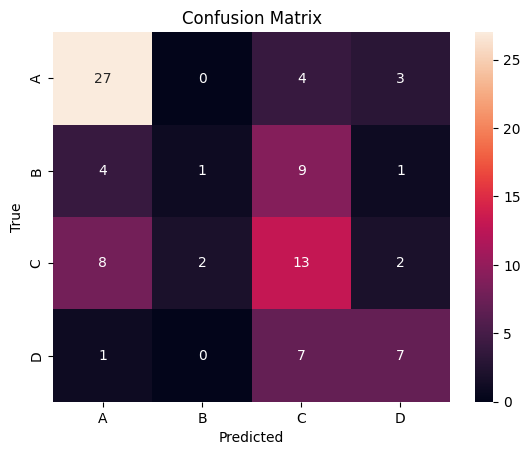

📦 Submission saved as submission.csv


In [2]:
import os
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

# Paths
base_path = "/kaggle/input/shl-intern-hiring-assessment/dataset"
audio_train_path = os.path.join(base_path, "audios_train")
audio_test_path = os.path.join(base_path, "audios_test")

# Load data
train_df = pd.read_csv(os.path.join(base_path, "train.csv"))
test_df = pd.read_csv(os.path.join(base_path, "test.csv"))

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Grade mapping (merge rare classes)
def score_to_grade(score):
    if score >= 4.25:
        return 'A'
    elif score >= 3.5:
        return 'B'
    elif score >= 2.5:
        return 'C'
    else:
        return 'D'  # Merged D + E

train_df['grade'] = train_df['label'].apply(score_to_grade)

# Debug class distribution
print("\nGrade distribution:")
print(train_df['grade'].value_counts())

# Extract features
def extract_features(file_path, n_mfcc=40):
    y, sr = librosa.load(file_path, sr=None)
    
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc.T, axis=0)
    mfcc_std = np.std(mfcc.T, axis=0)

    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    rms = np.mean(librosa.feature.rms(y=y))
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))

    return np.concatenate([mfcc_mean, mfcc_std, [zcr, rms, centroid]])

# Train features
train_features = []
for fname in train_df['filename']:
    path = os.path.join(audio_train_path, fname)
    train_features.append(extract_features(path))

X = np.array(train_features)
y = train_df['grade'].values

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)  # For classifier

# Train-test split (now safe, stratify works)
X_train, X_val, y_train, y_val = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# XGBoost Classifier
clf = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.08,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

clf.fit(X_train, y_train)

# Predict
val_preds = clf.predict(X_val)
acc = accuracy_score(y_val, val_preds)

print(f"\n✅ Validation Accuracy: {acc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_val, val_preds, target_names=le.classes_))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_val, val_preds), annot=True, fmt="d",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Test feature extraction
test_features = []
for fname in test_df['filename']:
    path = os.path.join(audio_test_path, fname)
    test_features.append(extract_features(path))

X_test = np.array(test_features)

# Predict test grades
test_preds = clf.predict(X_test)
test_grades = le.inverse_transform(test_preds)

# Create submission with dummy regression scores
submission = pd.DataFrame({
    'filename': test_df['filename'],
    'label': [4.5 if g == 'A' else 3.8 if g == 'B' else 2.8 if g == 'C' else 1.5 for g in test_grades]
})
submission.to_csv("submission.csv", index=False)
print("📦 Submission saved as submission.csv")
